In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from tools import pca_reduce, plot

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Classification

We explore different classification algorithms on a binary problem using the MNIST data

In [135]:
fname = 'mnist.npz'
#fname = 'galaxy.npz'

X = pca_reduce(np.load(fname)['X'], 2, whiten=True)
y = np.load(fname)['y']

In [136]:
X_orig = np.load(fname)['X']

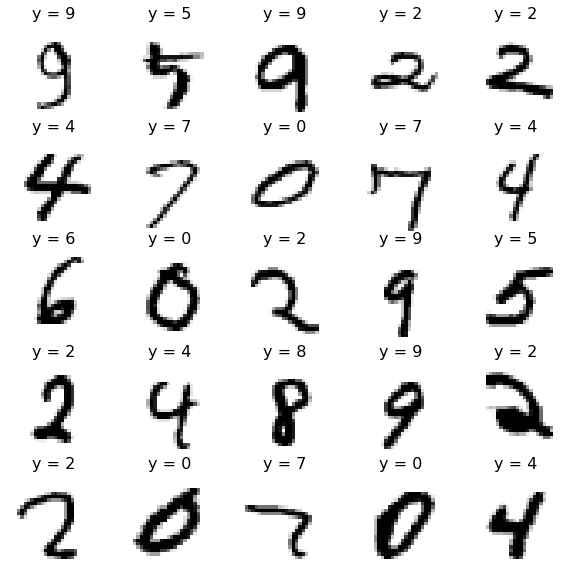

In [137]:
plot(X_orig, y)

We'll start with our standard PCE to 2d

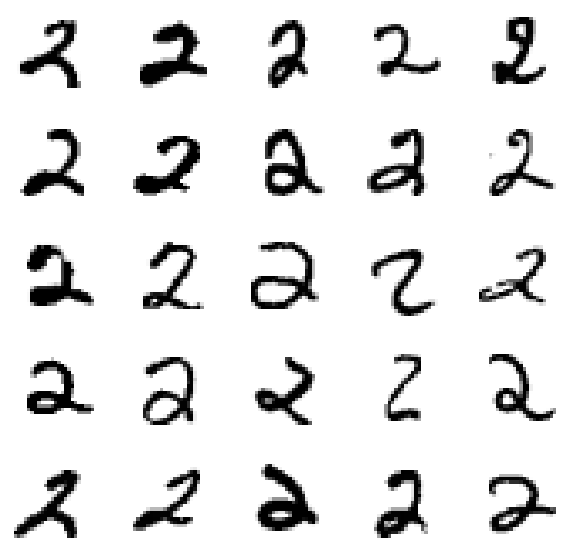

In [9]:
mask = y == 2
plot(X_orig[mask])

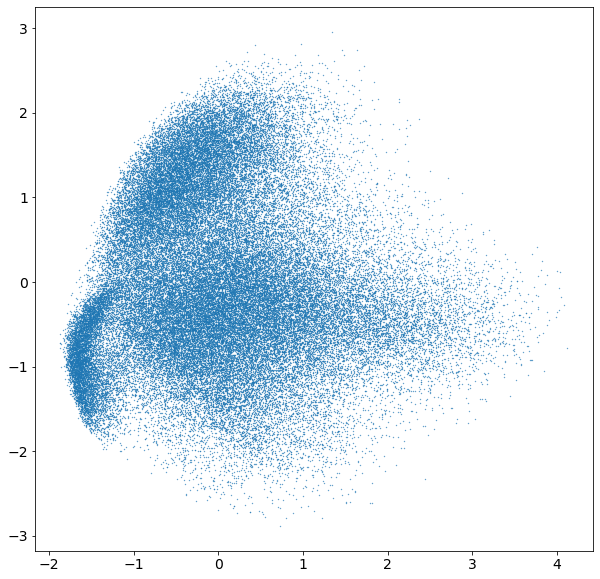

In [10]:
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, cmap=plt.cm.get_cmap('Spectral', 10))

The large difference to, for example clustering, is that now we have the truth lables! Let's plot them:

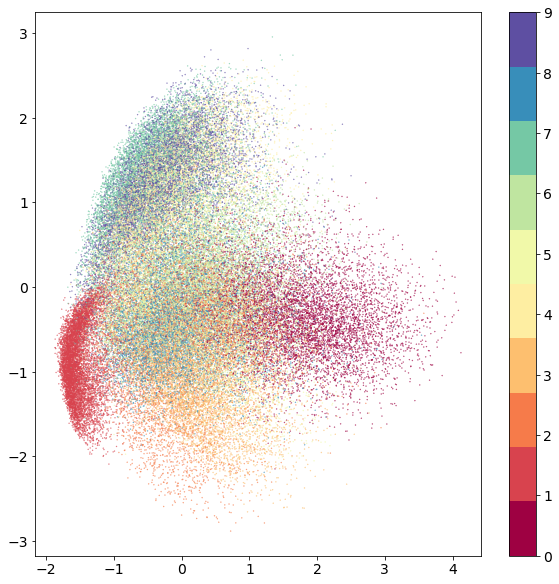

In [11]:
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, c=y ,cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar()

## Binary classification

To reduce the problem, we start with binary classification, trying to distinguish the digits (1, 4, 5, 7, 9) from the rest.

In [12]:
# do binary classification first (digits)
y = ((y == 1) | (y == 9) | (y == 5) | (y == 7) | (y == 4)).astype(np.float32)

# galaxy
# y = ((y == 0) | (y == 3)).astype(np.float32)

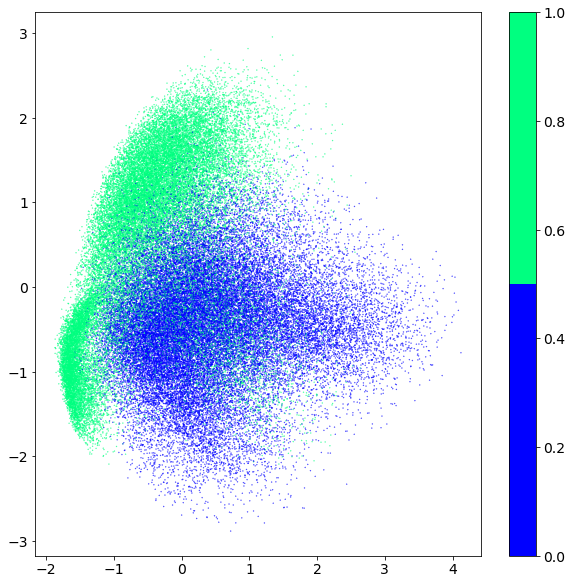

In [13]:
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, c=y ,cmap=plt.cm.get_cmap("winter", 2))
plt.colorbar()

# Decision Trees

let's suppose we can introduce a cut on a variable to separate the data intwo the two desired calsses.

What would we call a "good" cut?

In [14]:
p = y

In [16]:
def get_q(cut):
    q = np.zeros(len(X))
    mask = X[:, 1] > cut
    q[mask] = np.average(y[mask])
    q[~mask] = np.average(y[~mask])
    return q

In [17]:
q = get_q(0)

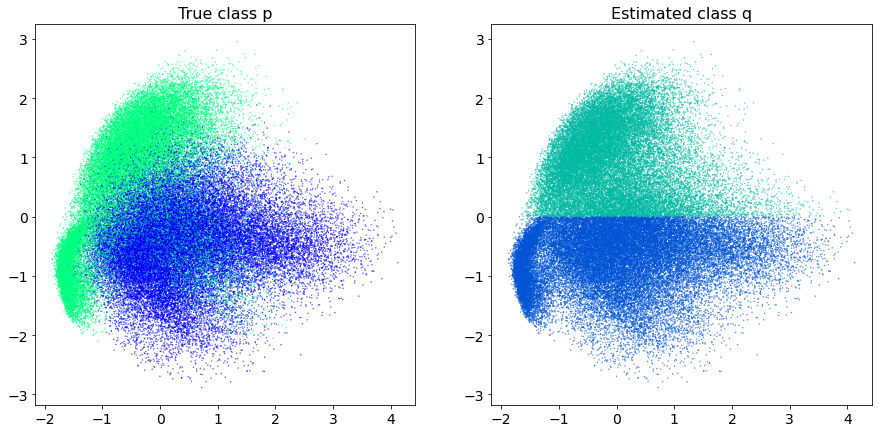

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].set_title("True class p")
plt_data = ax[0].scatter(X[:, 0], X[:, 1], s=0.1, c=p ,cmap=plt.cm.get_cmap("winter", 2))
ax[1].set_title("Estimated class q")
plt_data = ax[1].scatter(X[:, 0], X[:, 1], s=0.1, c=q ,cmap="winter", vmin=0, vmax=1)

In [19]:
-np.average((p * np.log(q) + (1-p) * np.log(1-q)))

0.6126189119589449

In [20]:
eps = 1e-15
-np.average((p * np.log(q + eps) + (1-p) * np.log(1-q + eps)))

0.6126189119589431

In [21]:
def loss(cut):
    q = get_q(cut)
    eps = 1e-15
    return -np.average((p * np.log(q + eps) + (1-p) * np.log(1-q + eps)))

In [22]:
cuts = np.linspace(-3, 3, 100)
losses = []
for cut in cuts:
    losses.append(loss(cut))

/home/peller/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/peller/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'loss')

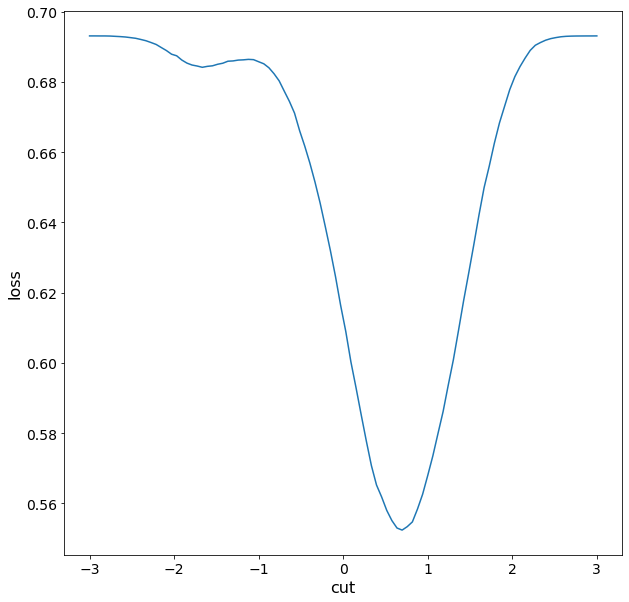

In [23]:
plt.plot(cuts, losses)
plt.gca().set_xlabel('cut')
plt.gca().set_ylabel('loss')

In [24]:
from scipy import optimize

In [25]:
res = optimize.minimize(loss, 0, options={'eps':1e-4})

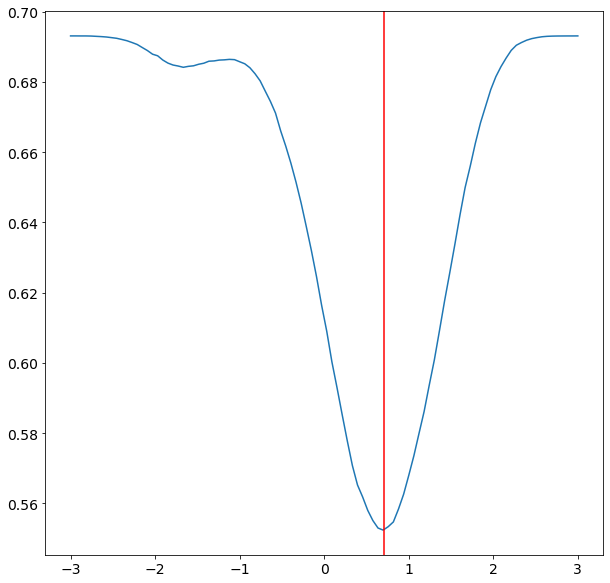

In [26]:
plt.plot(cuts, losses)
plt.axvline(res.x, c='r')

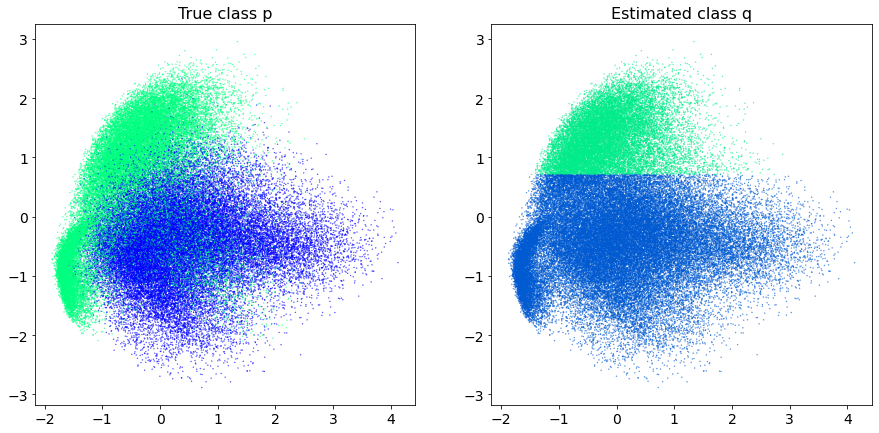

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

q = get_q(res.x)

ax[0].set_title("True class p")
plt_data = ax[0].scatter(X[:, 0], X[:, 1], s=0.1, c=p ,cmap=plt.cm.get_cmap("winter", 2))
ax[1].set_title("Estimated class q")
plt_data = ax[1].scatter(X[:, 0], X[:, 1], s=0.1, c=q ,cmap="winter", vmin=0, vmax=1)

We can perform this operation automatically via sklearn:

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [50]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

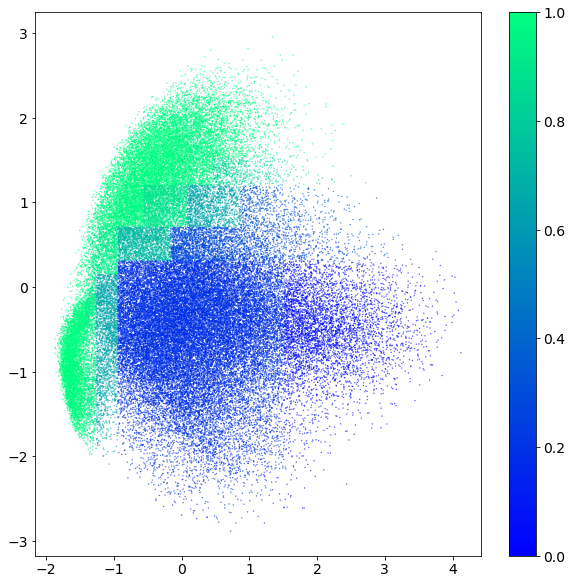

In [66]:
q = clf.predict_proba(X)
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, c=q[:, 1] ,cmap=plt.cm.get_cmap("winter"), vmin=0, vmax=1)
plt.colorbar()

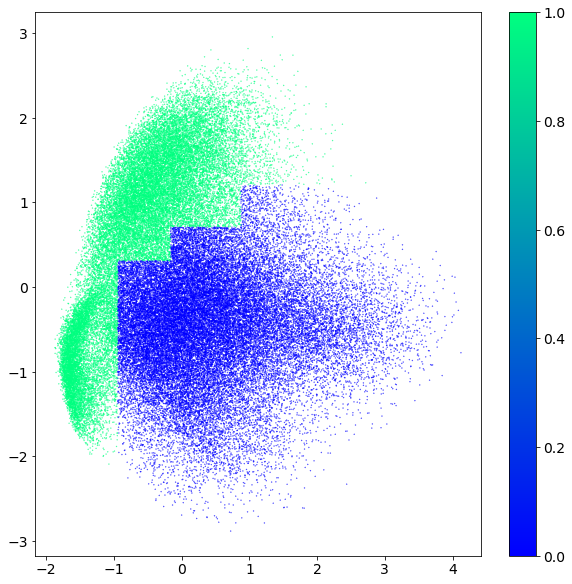

In [67]:
y_pred = clf.predict(X)
plt_data = plt.scatter(X[:, 0], X[:, 1], s=0.1, c=y_pred ,cmap=plt.cm.get_cmap("winter"), vmin=0, vmax=1)
plt.colorbar()

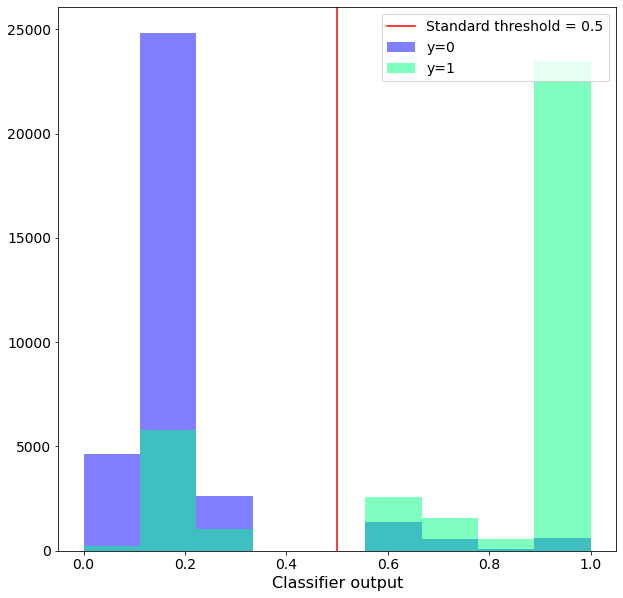

In [68]:
bins = np.linspace(0, 1, 10)
plt.hist(q[:,1][y==0], bins=bins, color=plt.cm.winter(0), label='y=0', alpha=0.5)
plt.hist(q[:,1][y==1], bins=bins, color=plt.cm.winter(1000), label='y=1', alpha=0.5)
plt.axvline(0.5, color='red', label = 'Standard threshold = 0.5')
plt.gca().set_xlabel("Classifier output")
plt.legend()

# FPR and TPR

In [53]:
def fpr_and_tpr(y, q, threshold=0.5):
    z = q[:, 0] > threshold
    y = y.astype(bool)
    TP = np.sum(y & z)
    TN = np.sum(~y & ~z)
    FP = np.sum(~y & z)
    FN = np.sum(y & ~z)
    
    return TP/(TP+FN), FP/(TN+FP)

In [54]:
tprs = []
fprs = []

for threshold in np.linspace(0, 1, 100):
    t,f = fpr_and_tpr(y, q, threshold)
    tprs.append(t)
    fprs.append(f)

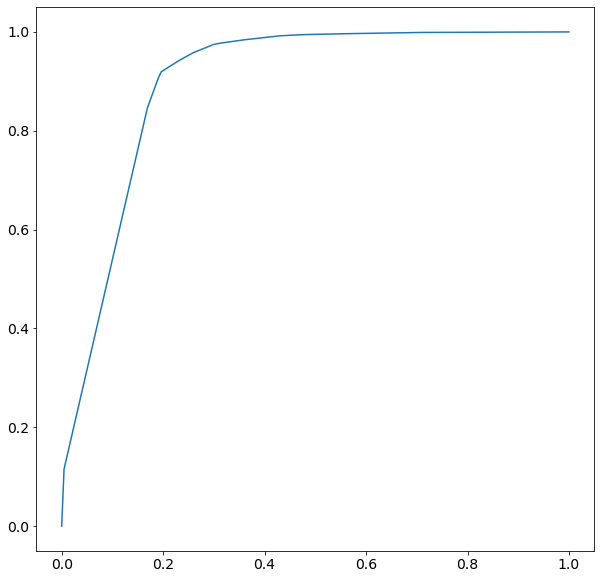

In [55]:
plt.plot(tprs, fprs)

## Train-Test splitting

We always need split data into independent training and testing samples for supervised learning!

In [57]:
X_train = X[:60000]
X_test = X[60000:]
y_train = y[:60000]
y_test = y[60000:]

In [316]:
# galaxy
# X_train = X[:8000]
# X_test = X[8000:]
# y_train = y[:8000]
# y_test = y[8000:]

In [76]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=30, max_depth=10, criterion="entropy") #DecisionTreeClassifier(max_depth=4))

#clf = DecisionTreeClassifier(max_depth=20, criterion="entropy")

clf.fit(X_train, y_train, )
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)
y_predicted_label = clf.predict(X_train)
y_test_predicted_label = clf.predict(X_test)

In [77]:
def plot_clf(y_predicted, y_test_predicted, y_predicted_label, y_test_predicted_label, nbins=100):
    fig, ax = plt.subplots(1, 2, figsize=(15,7))

    bins = np.linspace(0, 1, nbins)
    ax[0].hist(y_predicted[y_train==0][:,1], bins=bins, color=plt.cm.winter(0), label='Train (y=0)', alpha=0.5, density=True, hatch="\\\\\\\\", edgecolor='w', linewidth=0)
    ax[0].hist(y_predicted[y_train==1][:,1], bins=bins, color=plt.cm.winter(1000), label='Train (y=1)', alpha=0.5, density=True, hatch='////', edgecolor='k', linewidth=0)
    ax[0].hist(y_test_predicted[y_test==0][:,1], bins=bins, color=plt.cm.winter(0), histtype='step', lw=2, label='Test (y=0)', density=True)
    ax[0].hist(y_test_predicted[y_test==1][:,1], bins=bins, color='green', histtype='step', lw=2, label='Test (y=0)', density=True)
    ax[0].axvline(0.5, color='red', label = 'Standard threshold = 0.5')
    ax[0].set_xlabel("Classifier output")
    ax[0].legend()

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predicted[:,1])
    fpr_train, tpr_train, _ = roc_curve(y_train, y_predicted[:,1])
    bl = plt.plot(fpr_test, tpr_test, ls='-', label='Test (AUC = %0.2f)' %(auc(fpr_test, tpr_test)))
    ax[1].plot(fpr_train, tpr_train, ls='--', c=bl[0].get_color(), label='Train (AUC = %0.2f)' %(auc(fpr_train, tpr_train)))
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver operating characteristic')
    ax[1].legend(loc="lower right")

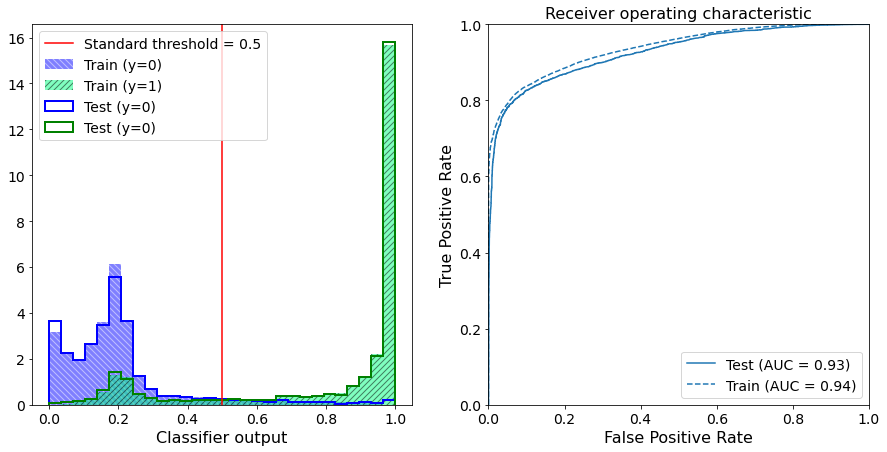

In [78]:
plot_clf(y_predicted, y_test_predicted, y_predicted_label, y_test_predicted_label, 30)

# Logistic Regression

This is the logictic function:

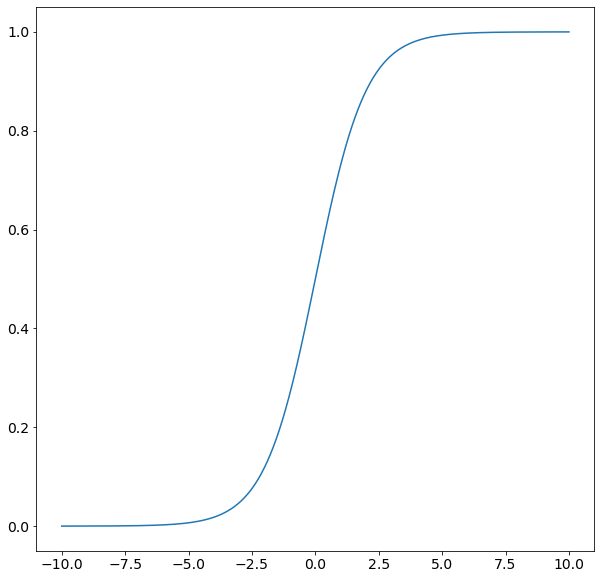

In [79]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, 1/(1+np.exp(-x)))

we can start by using a random guess:

In [108]:
params = np.random.randn(X.shape[1] + 1)

In [109]:
params

array([ 1.66985488, -0.12792481,  0.21231268])

In [82]:
p = 1 / (1 + np.exp(-(X_train @ params[:-1] + params[-1])))
-np.average((y_train * np.log(p) + (1-y_train) * np.log(1-p)))

0.7956122301142536

In [83]:
from scipy.special import expit

In [84]:
def loss(params):
    eps = 1e-7
    q = expit(X_train @ params[:-1] + params[-1])
    return - np.average((y_train * np.log(q+eps) + (1-y_train) * np.log(1-q+eps)))

In [85]:
loss(params)

0.7956120029528807

In [114]:
res = optimize.minimize(loss, params)
params = res.x

In [115]:
res.x

array([-1.64749409,  1.50392319, -0.14950252])

In [116]:
q = expit(X_train @ params[:-1] + params[-1])
q_test = expit(X_test @ params[:-1] + params[-1])

In [117]:
y_predicted = np.stack((1-q, q)).T
y_test_predicted = np.stack((1-q_test, q_test)).T

y_predicted_label = np.argmax(y_predicted, axis=1)
y_test_predicted_label = np.argmax(y_test_predicted, axis=1)

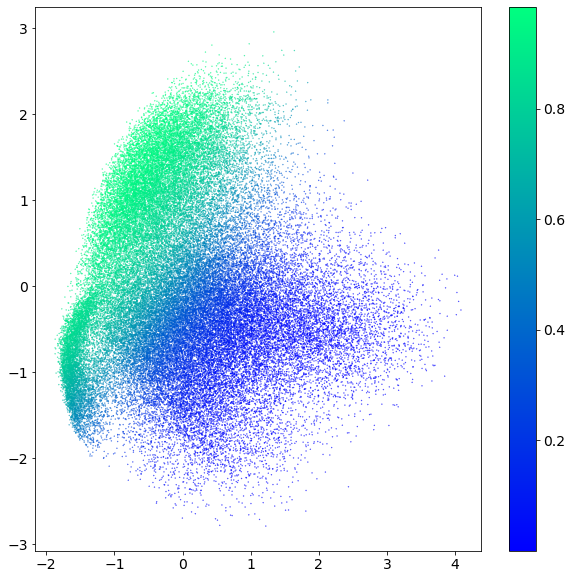

In [118]:
plt_data = plt.scatter(X_train[:, 0], X_train[:, 1], s=0.1, c=q ,cmap="winter")
plt.colorbar()

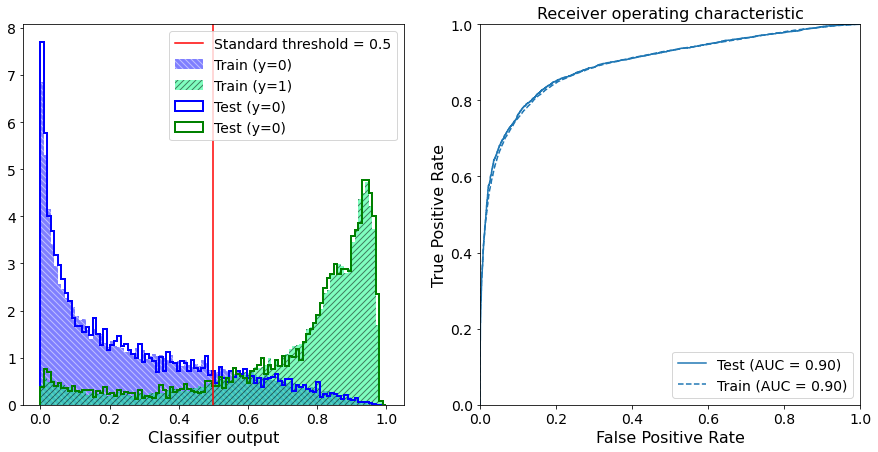

In [119]:
plot_clf(y_predicted, y_test_predicted, y_predicted_label, y_test_predicted_label)

# Different classifiers from sklearn

Use a classifier, try out different ones and different settings!

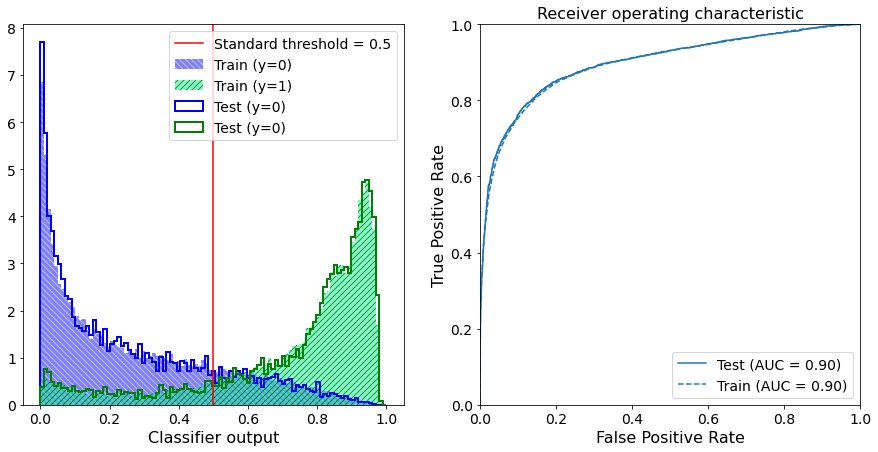

In [371]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train, )
y_predicted_label = clf.predict(X_train)
y_test_predicted_label = clf.predict(X_test)
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)
plot_clf(y_predicted, y_test_predicted, y_predicted_label, y_test_predicted_label)

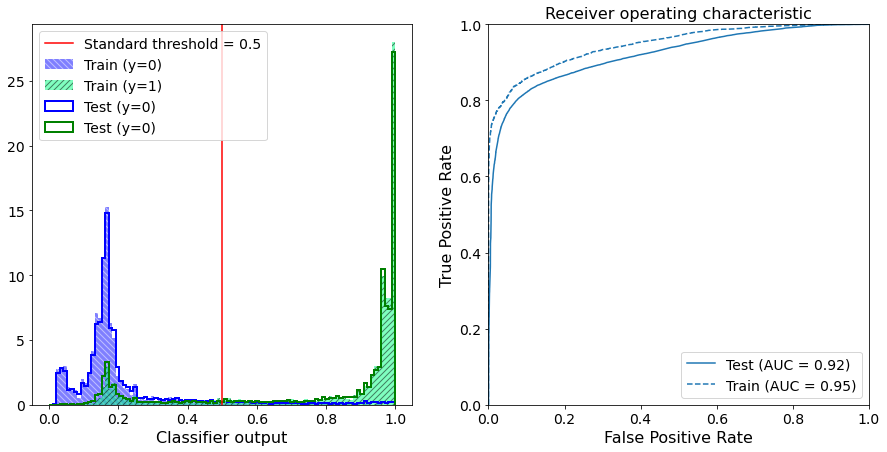

In [330]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, max_depth=7, criterion="entropy")
clf.fit(X_train, y_train, )
y_predicted_label = clf.predict(X_train)
y_test_predicted_label = clf.predict(X_test)
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)
plot_clf(y_predicted, y_test_predicted, y_predicted_label, y_test_predicted_label)

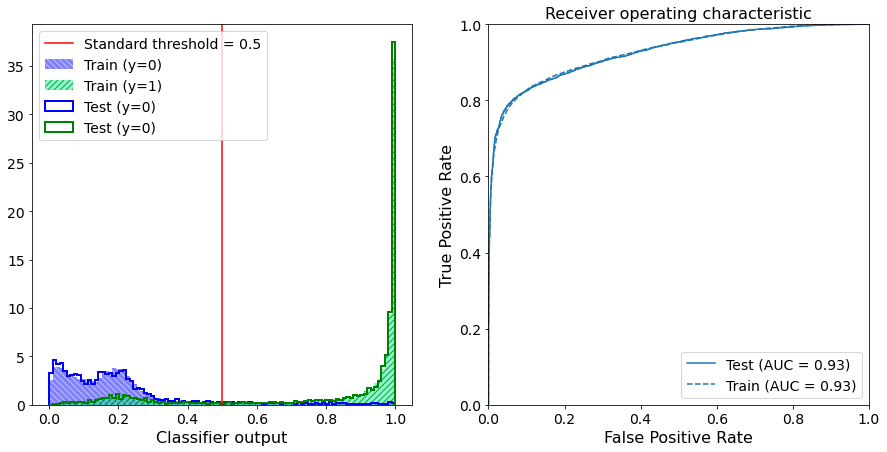

In [120]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=[64])
clf.fit(X_train, y_train, )
y_predicted_label = clf.predict(X_train)
y_test_predicted_label = clf.predict(X_test)
y_predicted = clf.predict_proba(X_train)
y_test_predicted = clf.predict_proba(X_test)
plot_clf(y_predicted, y_test_predicted, y_predicted_label, y_test_predicted_label)

In [87]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(max_depth=10, )
# name = 'max. depth = %s'%clf.max_depth

How well is the classification dping? We can construct the confusion matrix:

In [335]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predicted_label, )

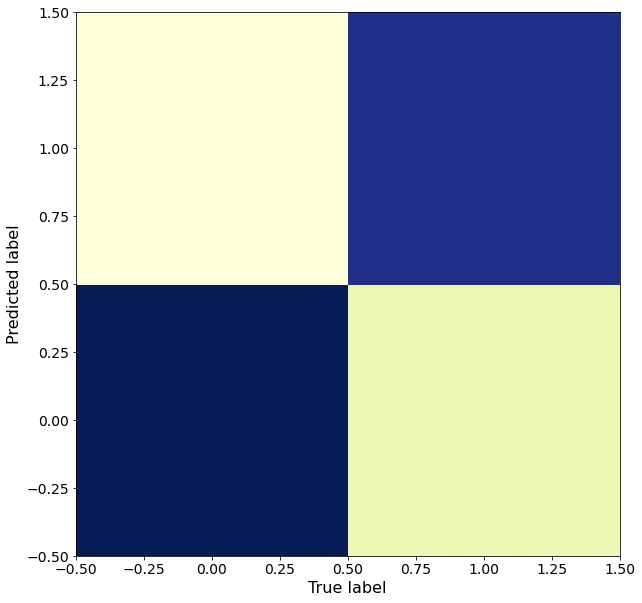

In [336]:
plt.imshow(cm.T, cmap='YlGnBu', origin='lower')
plt.gca().set_xlabel('True label')
plt.gca().set_ylabel('Predicted label')
plt.savefig('DT_confusion.png', bbox_inches='tight')

Here we plot some of the testing data that was preducted to be of class (1, 4, 5, 7, 9)

In [121]:
X_plot = X_orig[60000:]
#X_plot = X_orig[8000:]

Text(0.5, 0.98, 'Class: 1, 4, 5, 7, 9')

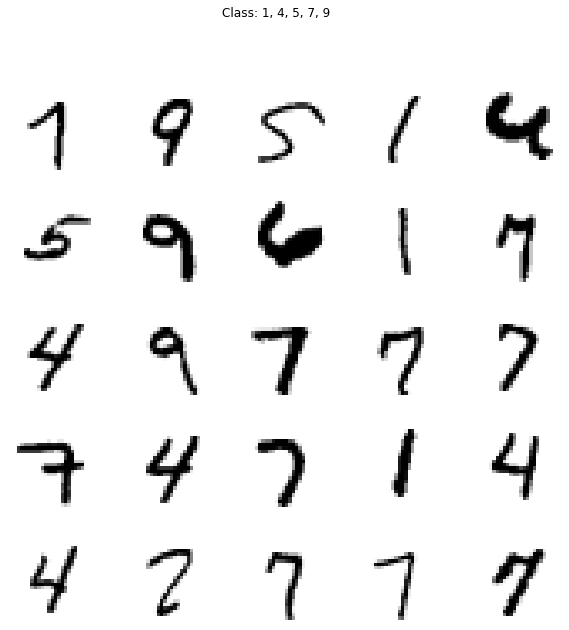

In [123]:
mask = y_test_predicted_label == 1
plot(X_plot[mask])    
plt.suptitle('Class: 1, 4, 5, 7, 9')
#plt.suptitle('Class: 0, 2, 3, 6, 8')
    
#plt.savefig('mnist.png', bbox_inches='tight')

In [340]:
len(y_test_predicted_label)

62000